In [1]:
from retentioneering import init_config
from retentioneering import datasets
import pandas as pd
import numpy as np


data = datasets.load_simple_shop()

<a id="1"></a>
# 1. Data preparation
[go to top](#0)

In [2]:
init_config(
    experiments_folder='experiments', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='client_id', # column by which we split users / sessions / whatever
    event_col='event', # column that describes event
    event_time_col='timestamp', # column that describes timestamp of event
    positive_target_event='passed', # name of positive target event
    negative_target_event='lost', # name of negative target event
    pos_target_definition={ # how to define positive event, e.g. empty means that add passed for whom was not 'lost'
        'event_list': ['payment_done']
    },
    neg_target_definition={}
)

data = data.retention.prepare()

# Split sessions

In [3]:
#example of trajectory without sessions
data[data['client_id']==219483890]

,client_id,event,timestamp
0,219483890,catalog,2019-11-01 17:59:13.273932
1,219483890,product1,2019-11-01 17:59:28.459271
2,219483890,cart,2019-11-01 17:59:29.502214
3,219483890,catalog,2019-11-01 17:59:32.557029
2096,219483890,main,2019-12-06 16:22:57.484842
2097,219483890,catalog,2019-12-06 16:23:01.331109
2098,219483890,catalog,2019-12-06 16:23:48.116617
4542,219483890,main,2020-01-06 22:10:13.635011
4543,219483890,catalog,2020-01-06 22:10:15.228575
4544,219483890,cart,2020-01-06 22:10:42.309028


In [4]:
#add sessions by time threshold:
data = data.retention.split_sessions(thresh=1800)
data[data['client_id']==219483890]

,client_id,event,timestamp,session_id
0,219483890,catalog,2019-11-01 17:59:13.273932,219483890_0
1,219483890,product1,2019-11-01 17:59:28.459271,219483890_0
2,219483890,cart,2019-11-01 17:59:29.502214,219483890_0
3,219483890,catalog,2019-11-01 17:59:32.557029,219483890_0
2096,219483890,main,2019-12-06 16:22:57.484842,219483890_1
2097,219483890,catalog,2019-12-06 16:23:01.331109,219483890_1
2098,219483890,catalog,2019-12-06 16:23:48.116617,219483890_1
4542,219483890,main,2020-01-06 22:10:13.635011,219483890_2
4543,219483890,catalog,2020-01-06 22:10:15.228575,219483890_2
4544,219483890,cart,2020-01-06 22:10:42.309028,219483890_2


In [5]:
data = data.retention.split_sessions(thresh=1800, eos_event = 'end_of_session')

In [6]:
data[data['client_id']==219483890]

,client_id,event,timestamp,session_id
0,219483890,catalog,2019-11-01 17:59:13.273932,219483890_0
1,219483890,product1,2019-11-01 17:59:28.459271,219483890_0
2,219483890,cart,2019-11-01 17:59:29.502214,219483890_0
3,219483890,catalog,2019-11-01 17:59:32.557029,219483890_0
4,219483890,end_of_session,2019-11-01 17:59:33.557029,219483890_0
2496,219483890,main,2019-12-06 16:22:57.484842,219483890_1
2497,219483890,catalog,2019-12-06 16:23:01.331109,219483890_1
2498,219483890,catalog,2019-12-06 16:23:48.116617,219483890_1
2499,219483890,end_of_session,2019-12-06 16:23:49.116617,219483890_1
5445,219483890,main,2020-01-06 22:10:13.635011,219483890_2


# Transitions weight functions

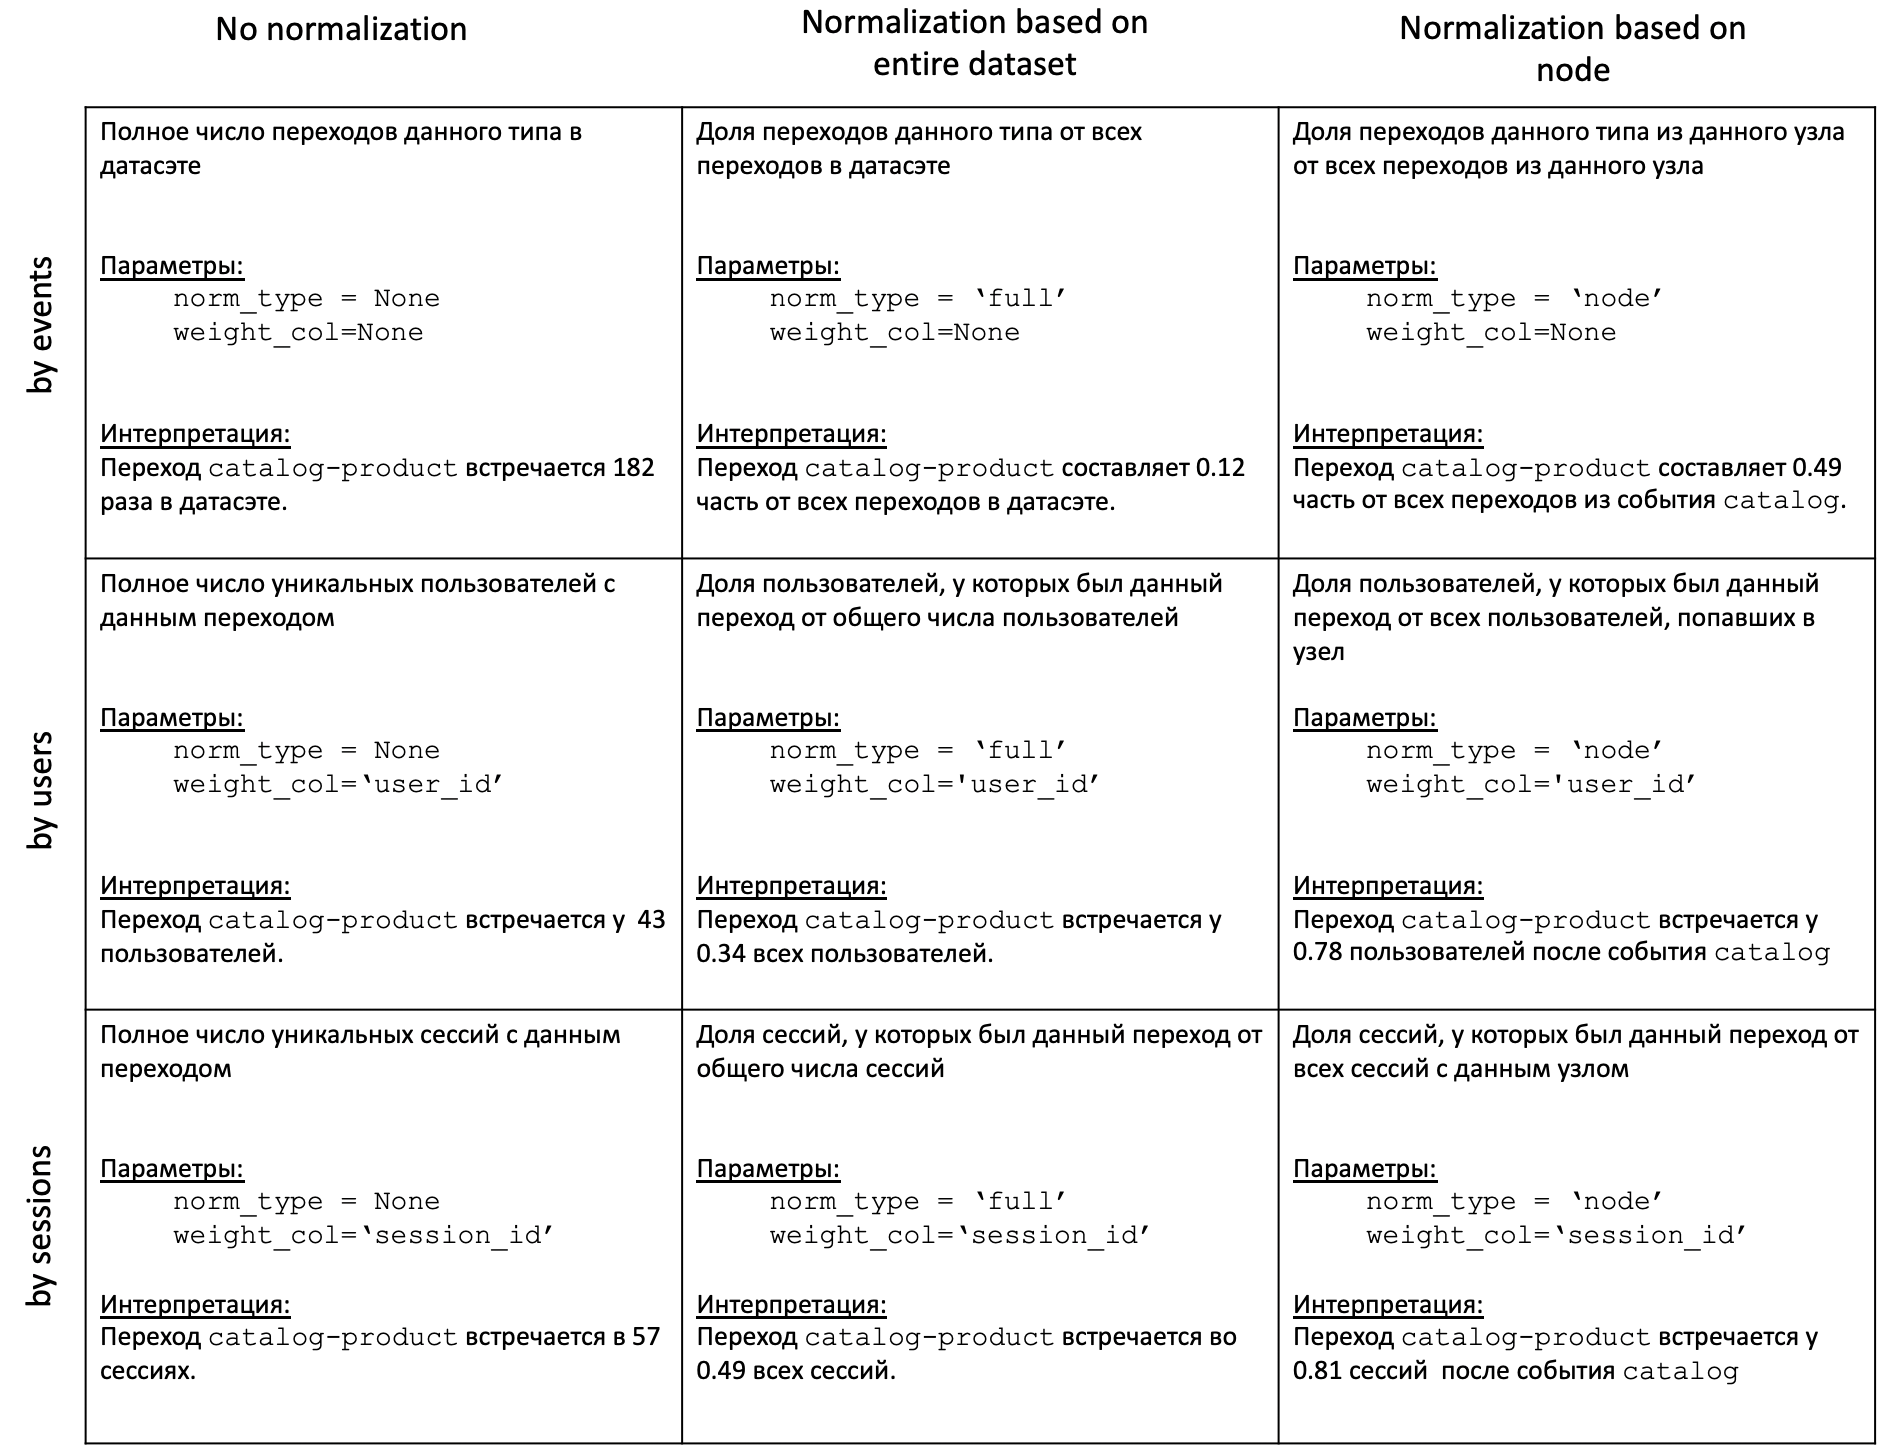

## Events: no normalization
```
norm_type=None,
weight_col=None
```

In [7]:
edgelist = data.retention.get_edgelist(norm_type=None,
                                       weight_col=None)

In [8]:
adj_matrix=data.retention.get_adjacency(norm_type=None,
                                        weight_col=None)
adj_matrix

,cart,catalog,delivery_choice,end_of_session,lost,main,product1,product2,delivery_courier,delivery_pickup,payment_choice,passed,payment_card,payment_cash
cart,1.0,571.0,1686.0,233.0,330.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
catalog,1709.0,4857.0,0.0,1132.0,1605.0,1413.0,1515.0,2172.0,0.0,0.0,0.0,0.0,0.0,0.0
delivery_choice,0.0,178.0,0.0,71.0,92.0,0.0,0.0,0.0,834.0,506.0,0.0,0.0,0.0,0.0
end_of_session,0.0,0.0,0.0,0.0,0.0,2703.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
main,0.0,4064.0,0.0,589.0,488.0,453.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product1,472.0,750.0,0.0,119.0,163.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product2,660.0,1298.0,0.0,91.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delivery_courier,0.0,0.0,0.0,34.0,46.0,0.0,0.0,0.0,0.0,0.0,752.0,0.0,0.0,0.0
delivery_pickup,0.0,0.0,0.0,56.0,92.0,0.0,0.0,0.0,0.0,0.0,355.0,0.0,0.0,0.0


In [9]:
data.retention.plot_graph(norm_type=None,
                          weight_col=None,
                          thresh=0.01)

'experiments/index_2020-08-29 21_50_26_438602.html'

## Events: normalized 'full'
```
norm_type='full',
weight_col=None
```

In [10]:
edgelist = data.retention.get_edgelist(norm_type='full',
                                       weight_col=None)

edgelist.sort_values('edge_weight', ascending=False).head()

,event,next_event,edge_weight
6,catalog,catalog,0.141467
24,main,catalog,0.118370
23,end_of_session,main,0.078729
11,catalog,product2,0.063263
5,catalog,cart,0.049777


In [11]:
adj_matrix=data.retention.get_adjacency(norm_type='full',
                                        weight_col=None)
adj_matrix

,cart,catalog,delivery_choice,end_of_session,lost,main,product1,product2,delivery_courier,delivery_pickup,payment_choice,passed,payment_card,payment_cash
cart,0.000029,0.016631,0.049107,0.006786,0.009612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog,0.049777,0.141467,0.000000,0.032971,0.046748,0.041156,0.044127,0.063263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_choice,0.000000,0.005185,0.000000,0.002068,0.002680,0.000000,0.000000,0.000000,0.024291,0.014738,0.000000,0.000000,0.000000,0.000000
end_of_session,0.000000,0.000000,0.000000,0.000000,0.000000,0.078729,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
main,0.000000,0.118370,0.000000,0.017156,0.014214,0.013194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
product1,0.013748,0.021845,0.000000,0.003466,0.004748,0.000029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
product2,0.019223,0.037806,0.000000,0.002651,0.003379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_courier,0.000000,0.000000,0.000000,0.000990,0.001340,0.000000,0.000000,0.000000,0.000000,0.000000,0.021903,0.000000,0.000000,0.000000
delivery_pickup,0.000000,0.000000,0.000000,0.001631,0.002680,0.000000,0.000000,0.000000,0.000000,0.000000,0.010340,0.000000,0.000000,0.000000


In [12]:
data.retention.plot_graph(norm_type='full',
                          weight_col=None,
                          thresh=0.01)

'experiments/index_2020-08-29 21_50_26_647304.html'

## Events: normalized 'node'
```
norm_type='node',
weight_col=None
```

In [13]:
edgelist = data.retention.get_edgelist(norm_type='node',
                                       weight_col=None,)

edgelist.sort_values('edge_weight', ascending=False).head()

,event,next_event,edge_weight
28,passed,end_of_session,1.000000
23,end_of_session,main,1.000000
31,payment_card,passed,0.905357
19,delivery_courier,payment_choice,0.903846
24,main,catalog,0.726493


In [14]:
adj_matrix=data.retention.get_adjacency(norm_type='node',
                                        weight_col=None)
adj_matrix

,cart,catalog,delivery_choice,end_of_session,lost,main,product1,product2,delivery_courier,delivery_pickup,payment_choice,passed,payment_card,payment_cash
cart,0.000354,0.202410,0.59766,0.082595,0.116980,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog,0.118656,0.337221,0.00000,0.078595,0.111435,0.098105,0.105186,0.150802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_choice,0.000000,0.105889,0.00000,0.042237,0.054729,0.000000,0.000000,0.000000,0.496133,0.301011,0.000000,0.000000,0.000000,0.000000
end_of_session,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lost,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
main,0.000000,0.726493,0.00000,0.105291,0.087236,0.080980,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
product1,0.313621,0.498339,0.00000,0.079070,0.108306,0.000664,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
product2,0.304850,0.599538,0.00000,0.042032,0.053580,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_courier,0.000000,0.000000,0.00000,0.040865,0.055288,0.000000,0.000000,0.000000,0.000000,0.000000,0.903846,0.000000,0.000000,0.000000
delivery_pickup,0.000000,0.000000,0.00000,0.111332,0.182903,0.000000,0.000000,0.000000,0.000000,0.000000,0.705765,0.000000,0.000000,0.000000


In [15]:
adj_matrix.sum(axis=1)

cart                1.0
catalog             1.0
delivery_choice     1.0
end_of_session      1.0
lost                0.0
main                1.0
product1            1.0
product2            1.0
delivery_courier    1.0
delivery_pickup     1.0
payment_choice      1.0
passed              1.0
payment_card        1.0
payment_cash        1.0
dtype: float64

In [16]:
data.retention.plot_graph(norm_type='node',
                          weight_col=None,
                          thresh=0.01)

'experiments/index_2020-08-29 21_50_26_842867.html'

## Users: no normalization
```
norm_type=None,
weight_col='client_id'
```

In [17]:
edgelist = data.retention.get_edgelist(norm_type=None,
                                       weight_col='client_id',)

edgelist.sort_values('edge_weight', ascending=False).head()

,event,next_event,edge_weight
24,main,catalog,2015
6,catalog,catalog,2004
8,catalog,lost,1605
11,catalog,product2,1430
2,cart,delivery_choice,1356


In [18]:
adj_matrix=data.retention.get_adjacency(norm_type=None, 
                                        weight_col='client_id', )
adj_matrix

,cart,catalog,delivery_choice,end_of_session,lost,main,product1,product2,delivery_courier,delivery_pickup,payment_choice,passed,payment_card,payment_cash
cart,1.0,478.0,1356.0,204.0,330.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
catalog,1324.0,2004.0,0.0,794.0,1605.0,1020.0,1122.0,1430.0,0.0,0.0,0.0,0.0,0.0,0.0
delivery_choice,0.0,172.0,0.0,68.0,92.0,0.0,0.0,0.0,748.0,469.0,0.0,0.0,0.0,0.0
end_of_session,0.0,0.0,0.0,0.0,0.0,1302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
main,0.0,2015.0,0.0,304.0,488.0,364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product1,431.0,620.0,0.0,113.0,163.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product2,582.0,934.0,0.0,88.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delivery_courier,0.0,0.0,0.0,34.0,46.0,0.0,0.0,0.0,0.0,0.0,683.0,0.0,0.0,0.0
delivery_pickup,0.0,0.0,0.0,55.0,92.0,0.0,0.0,0.0,0.0,0.0,332.0,0.0,0.0,0.0


In [19]:
data.retention.plot_graph(norm_type=None,
                          weight_col='client_id')

'experiments/index_2020-08-29 21_50_27_078733.html'

## Users: normalized 'full'
```
norm_type='full',
weight_col='client_id'
```

In [20]:
edgelist = data.retention.get_edgelist(norm_type='full', 
                                       weight_col='client_id')

edgelist.sort_values('edge_weight', ascending=False).head()

,event,next_event,edge_weight
24,main,catalog,0.537190
6,catalog,catalog,0.534258
8,catalog,lost,0.427886
11,catalog,product2,0.381232
2,cart,delivery_choice,0.361504


In [21]:
adj_matrix=data.retention.get_adjacency(norm_type='full', 
                                        weight_col='client_id',)
adj_matrix

,cart,catalog,delivery_choice,end_of_session,lost,main,product1,product2,delivery_courier,delivery_pickup,payment_choice,passed,payment_card,payment_cash
cart,0.000267,0.127433,0.361504,0.054385,0.087977,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog,0.352973,0.534258,0.000000,0.211677,0.427886,0.271927,0.29912,0.381232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_choice,0.000000,0.045854,0.000000,0.018128,0.024527,0.000000,0.00000,0.000000,0.199413,0.125033,0.000000,0.000000,0.000000,0.000000
end_of_session,0.000000,0.000000,0.000000,0.000000,0.000000,0.347107,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
main,0.000000,0.537190,0.000000,0.081045,0.130099,0.097041,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
product1,0.114903,0.165289,0.000000,0.030125,0.043455,0.000267,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
product2,0.155159,0.249000,0.000000,0.023460,0.030925,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_courier,0.000000,0.000000,0.000000,0.009064,0.012263,0.000000,0.00000,0.000000,0.000000,0.000000,0.182085,0.000000,0.000000,0.000000
delivery_pickup,0.000000,0.000000,0.000000,0.014663,0.024527,0.000000,0.00000,0.000000,0.000000,0.000000,0.088510,0.000000,0.000000,0.000000


In [22]:
data.retention.plot_graph(norm_type='full',
                          weight_col='client_id')

'experiments/index_2020-08-29 21_50_27_254907.html'

## Users: normalized 'node'
```
norm_type='node',
weight_col='client_id'
```

In [23]:
edgelist = data.retention.get_edgelist(norm_type='node',
                                       weight_col='client_id',)

edgelist.sort_values('edge_weight', ascending=False).head()

,event,next_event,edge_weight
23,end_of_session,main,1.000000
19,delivery_courier,payment_choice,0.913102
31,payment_card,passed,0.911708
24,main,catalog,0.844864
22,delivery_pickup,payment_choice,0.707889


In [24]:
adj_matrix=data.retention.get_adjacency(norm_type='node', 
                                        weight_col='client_id',)
adj_matrix

,cart,catalog,delivery_choice,end_of_session,lost,main,product1,product2,delivery_courier,delivery_pickup,payment_choice,passed,payment_card,payment_cash
cart,0.000520,0.248441,0.704782,0.106029,0.171518,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
catalog,0.366657,0.554971,0.000000,0.219884,0.444475,0.282470,0.310717,0.396012,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
delivery_choice,0.000000,0.126844,0.000000,0.050147,0.067847,0.000000,0.000000,0.000000,0.551622,0.34587,0.000000,0.000000,0.000000,0.00000
end_of_session,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
main,0.000000,0.844864,0.000000,0.127463,0.204612,0.152621,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
product1,0.384135,0.552585,0.000000,0.100713,0.145276,0.000891,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
product2,0.406993,0.653147,0.000000,0.061538,0.081119,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
delivery_courier,0.000000,0.000000,0.000000,0.045455,0.061497,0.000000,0.000000,0.000000,0.000000,0.00000,0.913102,0.000000,0.000000,0.00000
delivery_pickup,0.000000,0.000000,0.000000,0.117271,0.196162,0.000000,0.000000,0.000000,0.000000,0.00000,0.707889,0.000000,0.000000,0.00000


In [25]:
adj_matrix.sum(axis=1)

cart                1.231289
catalog             2.575187
delivery_choice     1.142330
end_of_session      1.000000
lost                0.000000
main                1.329560
product1            1.183601
product2            1.202797
delivery_courier    1.020053
delivery_pickup     1.021322
payment_choice      1.088727
passed              0.370597
payment_card        1.013436
payment_cash        1.005263
dtype: float64

In [26]:
data.retention.plot_graph(norm_type='node',
                          weight_col='client_id')

'experiments/index_2020-08-29 21_50_27_470128.html'

## Sessions: no normalization
```
norm_type=None,
weight_col='session_id'
```

In [27]:
edgelist = data.retention.get_edgelist(norm_type=None,
                                       weight_col='session_id',)

edgelist.sort_values('edge_weight', ascending=False).head()

,event,next_event,edge_weight
24,main,catalog,3319
23,end_of_session,main,2703
6,catalog,catalog,2551
11,catalog,product2,1719
2,cart,delivery_choice,1610


In [28]:
adj_matrix=data.retention.get_adjacency(norm_type=None, 
                                        weight_col='session_id',)
adj_matrix

,cart,catalog,delivery_choice,end_of_session,lost,main,product1,product2,delivery_courier,delivery_pickup,payment_choice,passed,payment_card,payment_cash
cart,1.0,515.0,1610.0,233.0,330.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
catalog,1566.0,2551.0,0.0,1132.0,1605.0,1146.0,1301.0,1719.0,0.0,0.0,0.0,0.0,0.0,0.0
delivery_choice,0.0,176.0,0.0,71.0,92.0,0.0,0.0,0.0,826.0,502.0,0.0,0.0,0.0,0.0
end_of_session,0.0,0.0,0.0,0.0,0.0,2703.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
main,0.0,3319.0,0.0,589.0,488.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product1,455.0,664.0,0.0,119.0,163.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product2,628.0,1063.0,0.0,91.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delivery_courier,0.0,0.0,0.0,34.0,46.0,0.0,0.0,0.0,0.0,0.0,744.0,0.0,0.0,0.0
delivery_pickup,0.0,0.0,0.0,56.0,92.0,0.0,0.0,0.0,0.0,0.0,351.0,0.0,0.0,0.0


In [29]:
data.retention.plot_graph(norm_type=None,
                          weight_col='session_id')

'experiments/index_2020-08-29 21_50_27_687383.html'

## Sessions: normalized 'full'
```
norm_type='full',
weight_col='session_id'
```

In [30]:
edgelist = data.retention.get_edgelist(norm_type='full',
                                       weight_col='session_id',)

edgelist.sort_values('edge_weight', ascending=False).head()

,event,next_event,edge_weight
24,main,catalog,0.514255
23,end_of_session,main,0.418810
6,catalog,catalog,0.395259
11,catalog,product2,0.266346
2,cart,delivery_choice,0.249458


In [31]:
adj_matrix=data.retention.get_adjacency(norm_type='full', 
                                        weight_col='session_id',)
adj_matrix

,cart,catalog,delivery_choice,end_of_session,lost,main,product1,product2,delivery_courier,delivery_pickup,payment_choice,passed,payment_card,payment_cash
cart,0.000155,0.079795,0.249458,0.036102,0.051131,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog,0.242640,0.395259,0.000000,0.175395,0.248683,0.177564,0.20158,0.266346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_choice,0.000000,0.027270,0.000000,0.011001,0.014255,0.000000,0.00000,0.000000,0.127983,0.077781,0.000000,0.000000,0.000000,0.000000
end_of_session,0.000000,0.000000,0.000000,0.000000,0.000000,0.418810,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
main,0.000000,0.514255,0.000000,0.091261,0.075612,0.061977,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
product1,0.070499,0.102882,0.000000,0.018438,0.025256,0.000155,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
product2,0.097304,0.164704,0.000000,0.014100,0.017973,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_courier,0.000000,0.000000,0.000000,0.005268,0.007127,0.000000,0.00000,0.000000,0.000000,0.000000,0.115277,0.000000,0.000000,0.000000
delivery_pickup,0.000000,0.000000,0.000000,0.008677,0.014255,0.000000,0.00000,0.000000,0.000000,0.000000,0.054385,0.000000,0.000000,0.000000


In [32]:
data.retention.plot_graph(norm_type='full',
                          weight_col='session_id')

'experiments/index_2020-08-29 21_50_27_880311.html'

## Sessions: normalized 'node'
```
norm_type='node',
weight_col='session_id'
```

In [33]:
edgelist = data.retention.get_edgelist(norm_type='node',
                                       weight_col='session_id',)

edgelist.sort_values('edge_weight', ascending=False).head()

,event,next_event,edge_weight
23,end_of_session,main,1.000000
19,delivery_courier,payment_choice,0.900726
31,payment_card,passed,0.897345
24,main,catalog,0.765099
22,delivery_pickup,payment_choice,0.699203


In [34]:
adj_matrix=data.retention.get_adjacency(norm_type='node', 
                                        weight_col='session_id',)
adj_matrix

,cart,catalog,delivery_choice,end_of_session,lost,main,product1,product2,delivery_courier,delivery_pickup,payment_choice,passed,payment_card,payment_cash
cart,0.000407,0.209605,0.655271,0.094831,0.134310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog,0.282671,0.460469,0.000000,0.204332,0.289711,0.206859,0.234838,0.310289,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_choice,0.000000,0.109317,0.000000,0.044099,0.057143,0.000000,0.000000,0.000000,0.513043,0.311801,0.000000,0.000000,0.000000,0.000000
end_of_session,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
main,0.000000,0.765099,0.000000,0.135777,0.112494,0.092208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
product1,0.349731,0.510377,0.000000,0.091468,0.125288,0.000769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
product2,0.365329,0.618383,0.000000,0.052938,0.067481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_courier,0.000000,0.000000,0.000000,0.041162,0.055690,0.000000,0.000000,0.000000,0.000000,0.000000,0.900726,0.000000,0.000000,0.000000
delivery_pickup,0.000000,0.000000,0.000000,0.111554,0.183267,0.000000,0.000000,0.000000,0.000000,0.000000,0.699203,0.000000,0.000000,0.000000


In [35]:
data.retention.plot_graph(norm_type='node',
                          weight_col='session_id')

'experiments/index_2020-08-29 21_50_28_089017.html'